In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import numpy as np
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/orobix/opt/anaconda3/envs/tesi

In [3]:
# original data directories
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict={CT:[], MRI:[], PET:[]}

for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]
    #print(len(myDict[path]))
    #print(myDict[path])


print(list(myDict.keys()))

#split train test
CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=0.8)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=0.8)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=0.8)

#split train validation
#CT_train, CT_validation = train_test_split(CT_train, train_size=0.75)
#MRI_train, MRI_validation = train_test_split(MRI_train, train_size=0.75)
#PET_train, PET_validation = train_test_split(PET_train, train_size=0.75)

#print(len(MRI_train))
#print(len(MRI_validation))
#print(len(MRI_test))


# unisco
train_file_names = CT_train + MRI_train + PET_train
#validation = CT_validation + MRI_validation + PET_validation
test_file_names = CT_test + MRI_test + PET_test
#label_test = len(CT_test)*['CT']

#print(label_test)
#print(CT_train)
#print(len(validation))
#print(test_file_names)

['../Data/CT/', '../Data/MRI/', '../Data/PET/']


In [4]:
# creo cartella data

print('Creo la cartella per i dati qui:', os.getcwd())

directories = ['data/train', 
               #'data/validation', 
               'data/test']

if not os.path.exists('data/'):
    for directory in directories:
        os.makedirs(directory)

scans = ['CT', 'MRI', 'PET']

for dest in directories:
    for source, scan in zip(myPaths, scans):
        files = eval(scan+'_train')
        #print(files)
        for f in files:
            shutil.copy(source+f, dest)

Creo la cartella per i dati qui: /Users/orobix/Documents/Thesis/Source/Code


Grandezza immagini: (128, 128)
TRAIN DATABASE: (851, 128, 128)
851
851


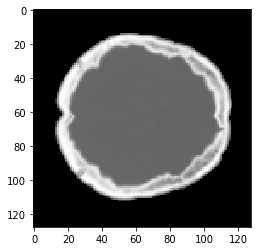

In [5]:
#creo l'array per passarlo poi al file come database

from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2

# lista per fare image reading
location_train_dir ='data/train/'
location_train_file_names = [location_train_dir + item for item in train_file_names]
#print(location_test_file_names)

#inizialize stack and resise x
x = io.imread(location_train_file_names[0])
x = cv2.resize(x, dsize=(128,128))
plt.imshow(x, cmap=plt.cm.gray)
print('Grandezza immagini:', x.shape)

#stack images
for img in location_train_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x = np.dstack((x,img))

#reshape and normalise
x = np.rollaxis(x,-1) #(182,218,N)->(N,182,218)
#x = x.reshape(-1, 128, 128, 1).astype('float32')
x = x/255. 
print('TRAIN DATABASE:', x.shape)

#creo lista di labels (y) per metrics
ext = '.png'
y = []
for text in listdir('data/train'):
    fileNameOnly = text[:text.find(ext)]
    y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))

#numero di clusters. (3)
n_clusters = len(np.unique(y))
print(len(x))
print(len(y))

In [6]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

## Base line K-Means clustering accuracy

In [7]:
new_x = x.reshape(x.shape[0],-1)
print(new_x.shape)

for i, item in enumerate(y):
    if item == 'CT':
        y[i] = '1'
    elif item == 'MRI':
        y[i] = '2'
    else: y[i] = '3'

new_y = np.array(y)
print(new_y.shape)

kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4, random_state=1)
y_pred_kmeans = kmeans.fit_predict(new_x)

(851, 16384)
(851,)


In [8]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [9]:
k_means_accuracy = acc(new_y, y_pred_kmeans)
print('L\'accuratezza calcolata con l\'algoritmo KMeans è:', k_means_accuracy)

L'accuratezza calcolata con l'algoritmo KMeans è: 0.3689776733254994


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


## Hyper-params

In [10]:
# to edit!
dims = [new_x.shape[-1], 500, 500, 2000, 3]

# ?
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 20
batch_size = 16

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
autoencoder, encoder = autoencoder(dims, init=init)

In [12]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(new_x, new_x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0904
Epoch 2/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0508
Epoch 3/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0193
Epoch 4/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0158
Epoch 5/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0151
Epoch 6/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0150
Epoch 7/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0146
Epoch 8/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0138
Epoch 9/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0141
Epoch 10/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0135
Epoch 11/20
851/851 [==============================] - 6s 7ms/step - loss: 0.0133
Epoch 12/20
851/851 [==============================] - 7s 8

In [13]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [14]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [15]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

TypeError: add_weight() got multiple values for argument 'name'